In [2]:
import os

# Graphics
import matplotlib.pyplot as plt
import seaborn
from pysal.viz import splot
from splot.esda import plot_moran
import contextily

# Analysis
import geopandas as gpd
import pandas as pd
from pysal.explore import esda
from pysal.lib import weights
from numpy.random import seed

c:\Users\Masat\Anaconda3\envs\my-stan\lib\site-packages\spaghetti\network.py:36: FutureWarning: The next major release of pysal/spaghetti (2.0.0) will drop support for all ``libpysal.cg`` geometries. This change is a first step in refactoring ``spaghetti`` that is expected to result in dramatically reduced runtimes for network instantiation and operations. Users currently requiring network and point pattern input as ``libpysal.cg`` geometries should prepare for this simply by converting to ``shapely`` geometries.
  warnings.warn(f"{dep_msg}", FutureWarning)


In [7]:
# Global variables
BASE_DIR = r"data/brexit"
BREXIT_CSV_PATH = os.path.join(BASE_DIR, r"brexit_vote.csv")
BREXIT_SHP_PATH = os.path.join(BASE_DIR, r"local_authority_districts.geojson")
TARGET_COL = "Pct_Leave"


In [15]:
df_brexit = pd.read_csv(BREXIT_CSV_PATH, index_col="Area_Code")
# df_brexit.info()

gdf_brexit = gpd.read_file(BREXIT_SHP_PATH)
gdf_brexit = gdf_brexit.set_index("lad16cd")
# gdf_brexit.info()

# gdfに投票のデータを結合する
gdf_brexit = gpd.GeoDataFrame(gdf_brexit.join(df_brexit[TARGET_COL]), crs=gdf_brexit.crs)
gdf_brexit = gdf_brexit.to_crs(epsg=3857)
gdf_brexit = gdf_brexit[["objectid", "lad16nm", TARGET_COL, "geometry"]]
gdf_brexit.dropna(inplace=True)

gdf_brexit.info()

del df_brexit

<class 'pandas.core.frame.DataFrame'>
Index: 382 entries, E06000031 to E08000036
Data columns (total 20 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   id                       382 non-null    int64  
 1   Region_Code              382 non-null    object 
 2   Region                   382 non-null    object 
 3   Area                     382 non-null    object 
 4   Electorate               382 non-null    int64  
 5   ExpectedBallots          382 non-null    int64  
 6   VerifiedBallotPapers     382 non-null    int64  
 7   Pct_Turnout              382 non-null    float64
 8   Votes_Cast               382 non-null    int64  
 9   Valid_Votes              382 non-null    int64  
 10  Remain                   382 non-null    int64  
 11  Leave                    382 non-null    int64  
 12  Rejected_Ballots         382 non-null    int64  
 13  No_official_mark         382 non-null    int64  
 14  Voting_for_both_a

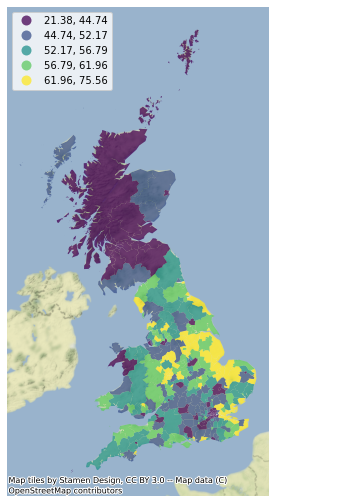

In [18]:
# Choropleth図を描画
# 最終的なプロットを読みやすくするために、いくつかの視覚的な調整（アルファ属性による透明化など）を行っていることに注目
f, ax = plt.subplots(1, figsize=(9, 9))
gdf_brexit.plot(
    column=TARGET_COL,
    cmap="viridis",
    scheme="quantiles",
    k=5,
    edgecolor="white",
    linewidth=0.0,
    alpha=0.75,
    legend=True,
    legend_kwds={"loc": 2},
    ax=ax,
)
# basemapを追加
contextily.add_basemap(
    ax,
    crs=gdf_brexit.crs,
    source=contextily.providers.Stamen.TerrainBackground,
)
ax.set_axis_off()

In [20]:
# Generate W from the GeoDataFrame
w = weights.KNN.from_dataframe(gdf_brexit, k=8)
# Row-standardization
w.transform = "R"

# Global spatial autocorrelation

In [23]:
# Calcurate Spatial Lag
gdf_brexit[TARGET_COL + "_lag"] = weights.spatial_lag.lag_spatial(
    w, gdf_brexit[TARGET_COL]
)
gdf_brexit.head()

,objectid,lad16nm,Pct_Leave,geometry,Pct_Leave_lag
lad16cd,,,,,
E06000001,1,Hartlepool,69.57,"MULTIPOLYGON (((-141402.215 7309092.065, -1537...",60.92125
E06000002,2,Middlesbrough,65.48,"MULTIPOLYGON (((-136924.099 7281563.141, -1426...",61.02625
E06000003,3,Redcar and Cleveland,66.19,"MULTIPOLYGON (((-126588.382 7293641.928, -1260...",60.65125
E06000004,4,Stockton-on-Tees,61.73,"MULTIPOLYGON (((-146690.634 7293316.144, -1537...",60.84375
E06000010,10,"Kingston upon Hull, City of",67.62,"MULTIPOLYGON (((-35191.009 7134866.244, -39368...",60.46750


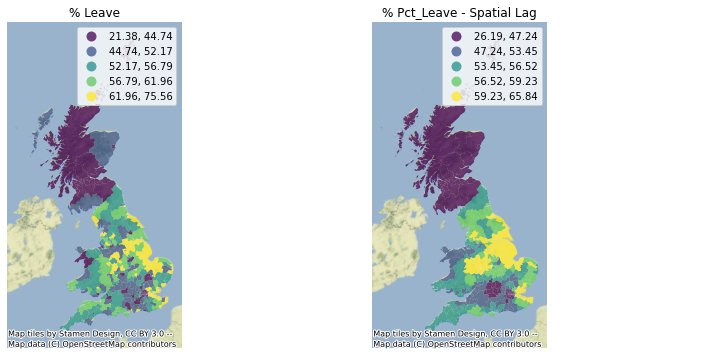

In [24]:
# Choropleth図とSpatial Lagをそれぞれ描画
f, axs = plt.subplots(1, 2, figsize=(12, 6))
ax1, ax2 = axs

gdf_brexit.plot(
    column=TARGET_COL,
    cmap="viridis",
    scheme="quantiles",
    k=5,
    edgecolor="white",
    linewidth=0.0,
    alpha=0.75,
    legend=True,
    ax=ax1,
)
ax1.set_axis_off()
ax1.set_title("% Leave")
contextily.add_basemap(
    ax1,
    crs=gdf_brexit.crs,
    source=contextily.providers.Stamen.TerrainBackground,
)

gdf_brexit.plot(
    column=TARGET_COL + "_lag",
    cmap="viridis",
    scheme="quantiles",
    k=5,
    edgecolor="white",
    linewidth=0.0,
    alpha=0.75,
    legend=True,
    ax=ax2,
)
ax2.set_axis_off()
ax2.set_title(f"% {TARGET_COL} - Spatial Lag")

contextily.add_basemap(
    ax2,
    crs=gdf_brexit.crs,
    source=contextily.providers.Stamen.TerrainBackground,
)

plt.show()

# Continuous case: Moran Plot and Moran's I

In [26]:
gdf_brexit[TARGET_COL + "_std"] = gdf_brexit[TARGET_COL] - gdf_brexit[TARGET_COL].mean()
gdf_brexit[TARGET_COL+"_lag_std"] = gdf_brexit[TARGET_COL + "_lag"] - gdf_brexit[TARGET_COL+"_lag"].mean()

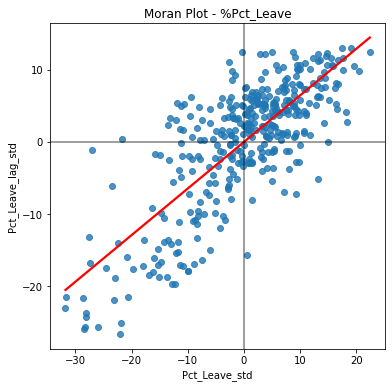

In [28]:
f, ax = plt.subplots(1, figsize=(6, 6))
seaborn.regplot(
    x=TARGET_COL+"_std",
    y=TARGET_COL+"_lag_std",
    ci=None,
    data=gdf_brexit,
    line_kws={"color": "r"},
)
ax.axvline(0, c="k", alpha=0.5)
ax.axhline(0, c="k", alpha=0.5)
ax.set_title(f"Moran Plot - %{TARGET_COL}")
plt.show()

In [34]:
# Calcurate Moran's I statistic
w.transform = "R"
moran = esda.moran.Moran(gdf_brexit["Pct_Leave"], w)

print(f"the value of Moran's I statistic: {moran.I :.3f}")
print(f"an empirical p-value of Moran'I statistic: {moran.p_sim :.3f}")

the value of Moran's I statistic: 0.645
an empirical p-value of Moran'I statistic: 0.001


(<Figure size 720x288 with 2 Axes>,
 array([<AxesSubplot:title={'center':'Reference Distribution'}, xlabel='Moran I: 0.65', ylabel='Density'>,
        <AxesSubplot:title={'center':'Moran Scatterplot (0.65)'}, xlabel='Attribute', ylabel='Spatial Lag'>],
       dtype=object))

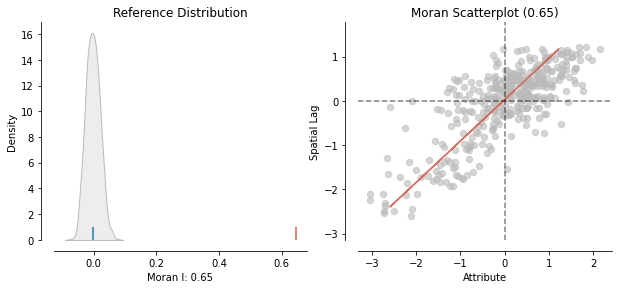

In [35]:
# Moran's Plot
plot_moran(moran)